In [24]:
import warnings

warnings.filterwarnings("ignore")

import logging
import random

import anndata2ri
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pertpy
import rpy2.rinterface_lib.callbacks
import sc_toolbox
import scanpy as sc
import seaborn as sns
from rpy2.robjects import pandas2ri

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [25]:
# Import Raw Data
adata = sc.read_h5ad('/home/glennrossdolan/Documents/gut-signaling-jakstat-ibd/06_data_repository/02_Pediatric_CD/raw_pediatric_chron_ileum.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 22502 × 33694
    obs: 'Age', 'Diagnosis', 'Sample name', 'Type', 'batch', 'doublet_scores', 'predicted_doublets', 'n_genes', 'percent_mito', 'n_counts', 'annotation_V2', 'inferred state', 'category'
    var: 'gene_ids'
    uns: 'Sample name_colors'


In [26]:
adata.obs[:5]

,Age,Diagnosis,Sample name,Type,batch,doublet_scores,predicted_doublets,n_genes,percent_mito,n_counts,annotation_V2,inferred state,category
index,,,,,,,,,,,,,
AAACGGGTCATAGCAC-1-4918STDY7273964,13,Crohn Disease,T017,Paediatric biopsy,4918STDY7273964,0.009254,False,1064,0.047925,4361.0,CD4 T cell,CD,T cells
AAAGATGAGTCCAGGA-1-4918STDY7273964,13,Crohn Disease,T017,Paediatric biopsy,4918STDY7273964,0.058431,False,1995,0.339954,5639.0,TA,CD,Epithelial
AAAGATGCAAGCCCAC-1-4918STDY7273964,13,Crohn Disease,T017,Paediatric biopsy,4918STDY7273964,0.012441,False,997,0.022129,4067.0,CD4 T cell,CD,T cells
AAAGATGTCAGTCAGT-1-4918STDY7273964,13,Crohn Disease,T017,Paediatric biopsy,4918STDY7273964,0.008289,False,1120,0.032266,4029.0,CD4 T cell,CD,T cells
AAAGATGTCTAACTTC-1-4918STDY7273964,13,Crohn Disease,T017,Paediatric biopsy,4918STDY7273964,0.050025,False,3783,0.079266,14773.0,TA,CD,Epithelial


In [28]:
# Check counts are raw
np.max(adata.X)

np.float32(42904.0)

In [29]:
# Save raw counts
adata.layers["counts"] = adata.X.copy()

In [30]:
# Count the number of patients
print('Control:', len(adata[adata.obs["Diagnosis"] != "Crohn Disease"].obs["Sample name"].cat.categories))
print('Chrons:', len(adata[adata.obs["Diagnosis"] == "Crohn Disease"].obs["Sample name"].cat.categories))

Control: 8
Chrons: 7


In [31]:
adata

AnnData object with n_obs × n_vars = 22502 × 33694
    obs: 'Age', 'Diagnosis', 'Sample name', 'Type', 'batch', 'doublet_scores', 'predicted_doublets', 'n_genes', 'percent_mito', 'n_counts', 'annotation_V2', 'inferred state', 'category'
    var: 'gene_ids'
    uns: 'Sample name_colors'
    layers: 'counts'

In [32]:
# Filter cells with less than 200 genes and genes which were found in less than 3 cells (rudimentary QC)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 22502 × 24192
    obs: 'Age', 'Diagnosis', 'Sample name', 'Type', 'batch', 'doublet_scores', 'predicted_doublets', 'n_genes', 'percent_mito', 'n_counts', 'annotation_V2', 'inferred state', 'category'
    var: 'gene_ids', 'n_cells'
    uns: 'Sample name_colors'
    layers: 'counts'

# Rename obs columns for consistency with tutorial

In [33]:
adata.obs = adata.obs.rename(columns={'Diagnosis': 'label'})
adata.obs = adata.obs.rename(columns={'Sample name': 'replicate'})
adata.obs = adata.obs.rename(columns={'annotation_V2': 'cell_type'})
adata

AnnData object with n_obs × n_vars = 22502 × 24192
    obs: 'Age', 'label', 'replicate', 'Type', 'batch', 'doublet_scores', 'predicted_doublets', 'n_genes', 'percent_mito', 'n_counts', 'cell_type', 'inferred state', 'category'
    var: 'gene_ids', 'n_cells'
    uns: 'Sample name_colors'
    layers: 'counts'

# Pseudobulk

In [34]:
adata.obs["sample"] = [
    f"{rep}_{l}" for rep, l in zip(adata.obs["replicate"], adata.obs["label"])
]

In [35]:
adata.obs["cell_type"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type"]]
adata.obs["cell_type"] = [ct.replace("+", "") for ct in adata.obs["cell_type"]]

In [36]:
adata.obs["replicate"] = adata.obs["replicate"].astype("category")
adata.obs["label"] = adata.obs["label"].astype("category")
adata.obs["sample"] = adata.obs["sample"].astype("category")
adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")

In [37]:
NUM_OF_CELL_PER_DONOR = 30


def aggregate_and_filter(
    adata,
    cell_identity,
    donor_key="sample",
    condition_key="label",
    cell_identity_key="cell_type",
    obs_to_keep=None,  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=1,
):
    # subset adata to the given cell identity
    if obs_to_keep is None:
        obs_to_keep = []
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    return adata_cell_pop

In [38]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [39]:
%%R
fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$label)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create a vector that is a concatenation of condition and cell type that we will later use with contrasts
    group <- paste0(colData(adata_)$label, ".", colData(adata_)$cell_type)
    replicate <- colData(adata_)$replicate
    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    design <- model.matrix(~ 0 + group + replicate)
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}

ValueError: Not an rpy2 R object and unable to map it to one: np.str_('value')

In [40]:
obs_to_keep = ["label", "cell_type", "replicate", "sample"]

In [41]:
adata.X = adata.layers["counts"].copy()

In [60]:
# process first cell type separately...
cell_type = adata.obs["cell_type"].cat.categories[0]
print(
    f'Processing {cell_type} (1 out of {len(adata.obs["cell_type"].cat.categories)})...'
)
adata_pb = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
for i, cell_type in enumerate(adata.obs["cell_type"].cat.categories[1:]):
    print(
        f'Processing {cell_type} ({i+2} out of {len(adata.obs["cell_type"].cat.categories)})...'
    )
    adata_cell_type = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
    adata_pb = adata_pb.concatenate(adata_cell_type)

Processing Activated_B_cell (1 out of 41)...
Dropping the following samples:
['T017_Crohn Disease', 'T019_Crohn Disease', 'T057_Normal control', 'T110_Normal control', 'T160_Normal control', 'T161_Normal control', 'T182_Normal control', 'T189_Crohn Disease', 'T197_Crohn Disease', 'T202_Crohn Disease', 'T203_Crohn Disease']


AttributeError: 'SparseCSRMatrixView' object has no attribute 'A'

In [41]:
adata_pb.layers['counts'] = adata_pb.X.copy()

In [42]:
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

In [44]:
adata_pb

AnnData object with n_obs × n_vars = 166 × 24192
    obs: 'label', 'cell_type', 'replicate', 'sample', 'batch', 'lib_size'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [48]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1).astype(float)  # Ensure float64
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

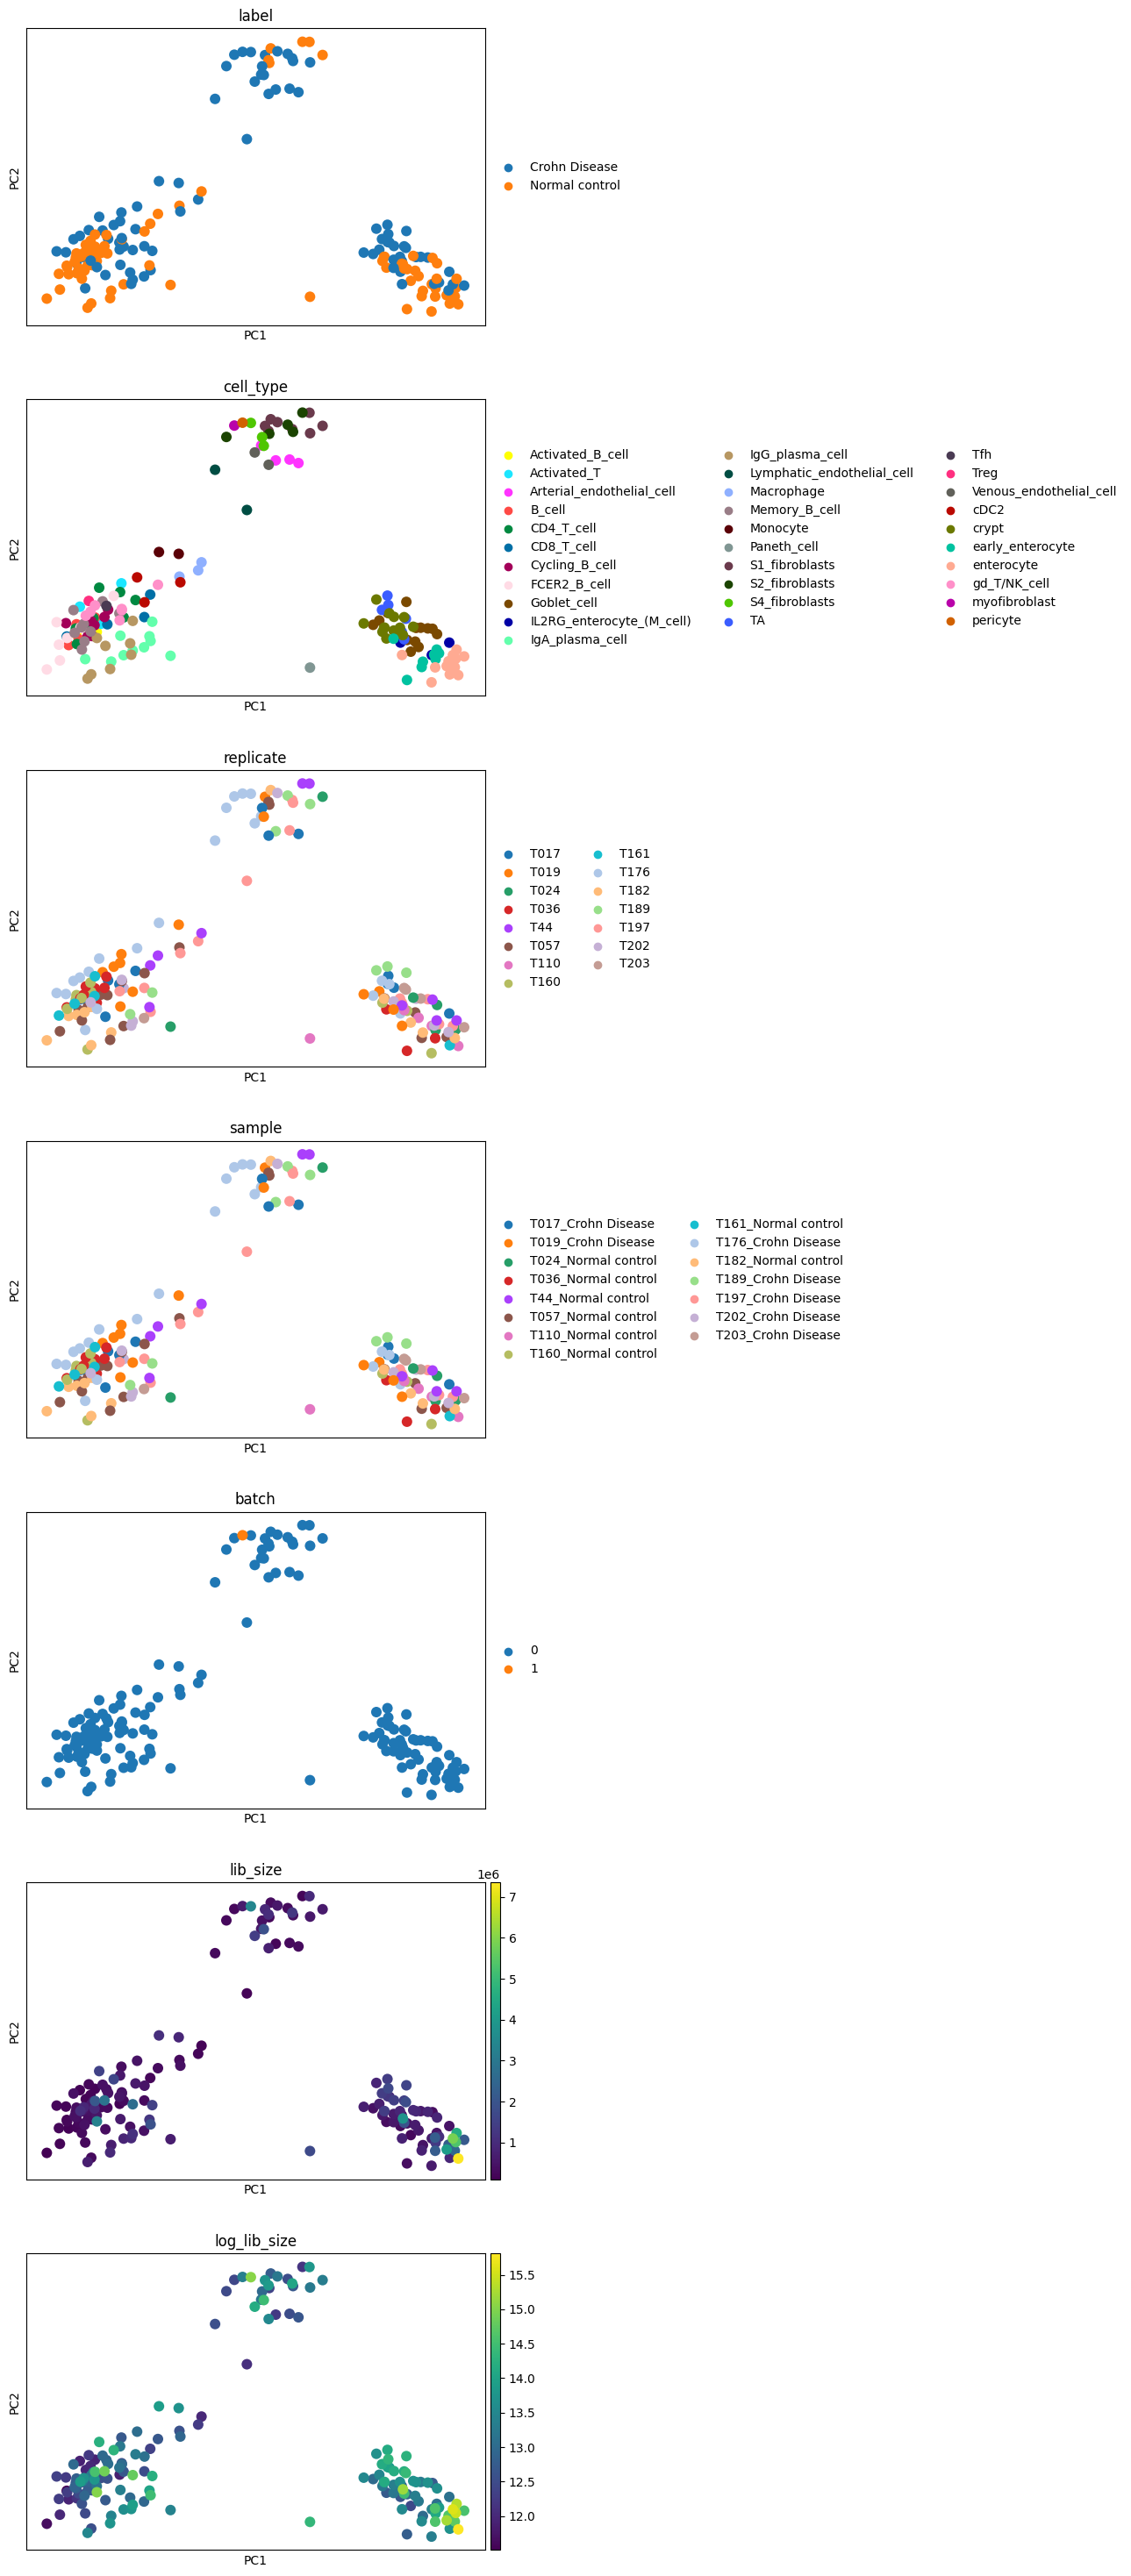

In [49]:
sc.pl.pca(adata_pb, color=adata_pb.obs, ncols=1, size=300)

In [50]:
adata_pb.X = adata_pb.layers['counts'].copy()

# 16.4.1. One group

In [51]:
adata_mono = adata_pb[adata_pb.obs["cell_type"] == "enterocyte"]
adata_mono

View of AnnData object with n_obs × n_vars = 12 × 24192
    obs: 'label', 'cell_type', 'replicate', 'sample', 'batch', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca', 'label_colors', 'cell_type_colors', 'replicate_colors', 'sample_colors', 'batch_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [52]:
adata_mono.obs_names = [
    name.split("_")[2] + "_" + name.split("_")[3] for name in adata_mono.obs_names
]

In [54]:
%%time
%%R -i adata_mono
outs <-fit_model(adata_mono)

NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'numpy.ndarray'>'

In [ ]:
%%R
fit <- outs$fit
y <- outs$y

In [ ]:
%%R
plotMDS(y, col=ifelse(y$samples$group == "stim", "red", "blue"))

In [ ]:
%%R
plotBCV(y)

In [ ]:
%%R
colnames(y$design)

In [ ]:
%%R -o tt
myContrast <- makeContrasts('groupstim.CD14_Monocytes-groupctrl.CD14_Monocytes', levels = y$design)
qlf <- glmQLFTest(fit, contrast=myContrast)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table

In [ ]:
tt.shape

In [ ]:
tt[:5]

In [ ]:
%%R
tr <- glmTreat(fit, contrast=myContrast, lfc=1.5)
print(head(topTags(tr)))

In [ ]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.01)])